# Assignment - Model Interpretability 


Interpret your models.

1. Fit a linear model and interpret the regression coefficients

2. Fit a tree-based model and interpret the nodes

3.  Use auto ml to find the best model

4. Run SHAP analysis on the models from steps 1, 2, and 3,   interpret the SHAP values and compare them with the other model interpretability methods.

# Context for the problem

Bob has started his own mobile company. He wants to give tough fight to big companies like Apple,Samsung etc.
He does not know how to estimate price of mobiles his company creates. In this competitive mobile phone market you cannot simply assume things. To solve this problem he collects sales data of mobile phones of various companies.
Bob wants to find out some relation between features of a mobile phone(eg:- RAM,Internal Memory etc) and its selling price. But he is not so good at Machine Learning. So he needs your help to solve this problem.
In this problem you do not have to predict actual price but a price range indicating how high the price is

# Install Packages

In [1]:
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future
!pip install shap
!pip install probatus==1.7.0


!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o



Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html


In [2]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Fill missing values with Scikit-Learn
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split

# Import libraries
# Use pip install or conda install if missing a library
import warnings
warnings.filterwarnings('ignore')
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# MAE
from sklearn.metrics import mean_absolute_error

# SHAP
import shap
from sklearn.feature_extraction.text import TfidfVectorizer



# Start AutoML Server

In [3]:
# Set a minimum memory size and a run time in seconds
min_mem_size=6 
run_time=222

# Use 50% of availible resources
pct_memory=0.75
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

# 65535 Highest port no
# Start the H2O server on a random port
port_no=random.randint(5555,55555)

#  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
try:
  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
except:
  logging.critical('h2o.init')
  h2o.download_all_logs(dirname=logs_path, filename=logfile)      
  h2o.cluster().shutdown()
  sys.exit(2)

5
Checking whether there is an H2O instance running at http://localhost:49484 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.14.1" 2022-02-08; OpenJDK Runtime Environment (build 11.0.14.1+1-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.14.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmppfl9j9z7
  JVM stdout: /tmp/tmppfl9j9z7/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmppfl9j9z7/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:49484
Connecting to H2O server at http://127.0.0.1:49484 ... successful.


H2O_cluster_uptime:,05 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.1
H2O_cluster_version_age:,11 days
H2O_cluster_name:,H2O_from_python_unknownUser_4pb60g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


# Load the data

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/pratikg17neu/DS_6105__Assignment1/proper-dataset/dataset/train.csv')
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [5]:
df.describe()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
count,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1238.518500,0.4950,1.522250,0.509500,4.309500,0.521500,32.046500,0.501750,140.249000,4.520500,...,645.108000,1251.515500,2124.213000,12.306500,5.767000,11.011000,0.761500,0.503000,0.507000,1.500000
std,439.418206,0.5001,0.816004,0.500035,4.341444,0.499662,18.145715,0.288416,35.399655,2.287837,...,443.780811,432.199447,1084.732044,4.213245,4.356398,5.463955,0.426273,0.500116,0.500076,1.118314
min,501.000000,0.0000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,...,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,851.750000,0.0000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,109.000000,3.000000,...,282.750000,874.750000,1207.500000,9.000000,2.000000,6.000000,1.000000,0.000000,0.000000,0.750000
50%,1226.000000,0.0000,1.500000,1.000000,3.000000,1.000000,32.000000,0.500000,141.000000,4.000000,...,564.000000,1247.000000,2146.500000,12.000000,5.000000,11.000000,1.000000,1.000000,1.000000,1.500000
75%,1615.250000,1.0000,2.200000,1.000000,7.000000,1.000000,48.000000,0.800000,170.000000,7.000000,...,947.250000,1633.000000,3064.500000,16.000000,9.000000,16.000000,1.000000,1.000000,1.000000,2.250000
max,1998.000000,1.0000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,8.000000,...,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,3.000000


# Checking Data and Null values

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

In [7]:
df.isna().sum()

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64

## As there are no null or missing values present and all values are numeric we dont need to clean the data.

# Training model on data set


## 1. LogisticRegression
## 2. RandomForestClassifier 
## 3. AutoML




# Preprating Test and Train Data

In [8]:
df = pd.read_csv('https://raw.githubusercontent.com/pratikg17neu/DS_6105__Assignment1/proper-dataset/dataset/train.csv')

X = df.drop("price_range", axis = 1)
y = df["price_range"]

# Create the X_train and y_train
X_train = df.drop("price_range", axis = 1)
y_train = df["price_range"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)
X_train.shape, X_test.shape

np.random.seed(42);

## 1.Performing Logistic Regression

In [9]:
lr_model = LogisticRegression(solver='liblinear')
lr_model.fit(X_train, y_train)
lr_model.score(X_test, y_test)

0.79

#### Logistics Regression Model has accuracy of `76.75%`

#### Mean Aboslute Error for Logistic Regression

In [10]:
y_preds = lr_model.predict(X_test)
mae = mean_absolute_error(y_test, y_preds)
mae

0.22

## 1.2 SHAP Value on Logistic Regression

### Using Linear Explainer

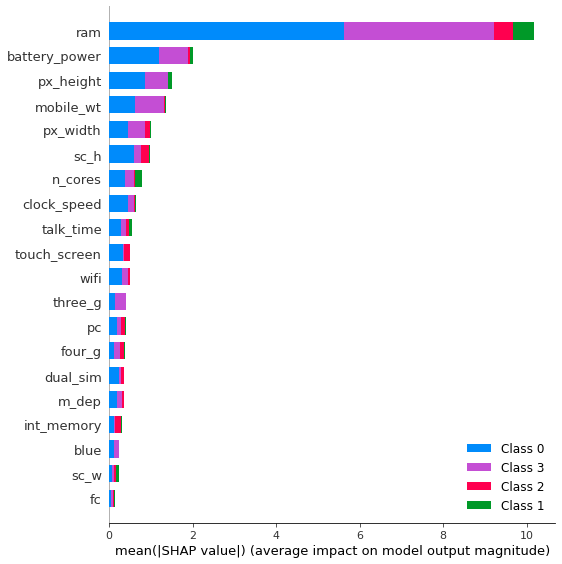

In [11]:
explainer = shap.LinearExplainer(lr_model, X_test)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

## We can see that the are 4 major variable which affect the pricing of the phone


1.   RAM
2.   Battery Power
3.   Pixel Height
4.   Weight of the phone




## Shap plot for Phone which is classified in 0 range (Lowest Price)

In [12]:
# y_test contain result of mobile class
y_test.iloc[1]

# y_test

0

In [13]:
ex = shap.KernelExplainer(lr_model.predict, X_test)
shap.initjs()

# Plotting for Mobile phone in 0 price range
shap_values = ex.shap_values(X_test.iloc[1,:])
shap.force_plot(ex.expected_value, shap_values, X_test.iloc[1,:])

Using 400 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


We can see that as the column contain data regarding the lowest price phone the due to the less ram size the price is lower

## Shap plot for Phone which is classified in 2 range (Medium Price)

In [14]:
# y_test contain result of mobile class
y_test.iloc[0]

3

In [15]:
# Plotting for Mobile phone in 2 price range
shap.initjs()
shap_values = ex.shap_values(X_test.iloc[0,:])
shap.force_plot(ex.expected_value, shap_values, X_test.iloc[0,:])

From the SHAP plot we can see that that `ram` feature is pushing the price of phone.

## Shap plot for Phone which is classified in 3 range (Highest Price)

In [16]:
# y_test contain result of mobile class
y_test.iloc[3]

1

In [17]:
# Plotting for Mobile phone in 2 price range
shap.initjs()
shap_values = ex.shap_values(X_test.iloc[3,:])
shap.force_plot(ex.expected_value, shap_values, X_test.iloc[3,:])

## Here we can see the difference for phone with more ram memory, battery, pixel height and weight is affects the price of the phone. The features in red impacts the output and pushes the price of the phone on the higher side on the other hand the variable in blue pulls the phone pricing down.

## Summary Plot for the first 100 test dataset

  0%|          | 0/100 [00:00<?, ?it/s]

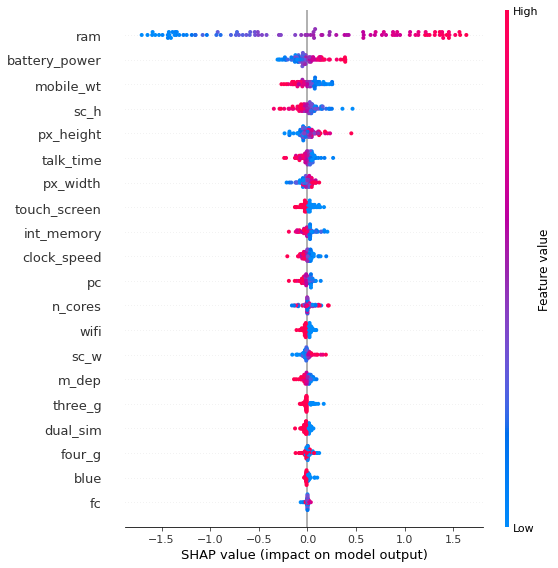

In [18]:
shap_values = ex.shap_values(X_test[:100])
shap.summary_plot(shap_values, X_test[:100])

Again from the summary plot we can deduce that the all the top four feature influence the output.

## Force plot for the dataset

In [19]:
shap.initjs()
shap.force_plot(ex.expected_value, shap_values, X_test)


Positive shap values are indicated in red, whereas negative shap values are shown in blue. For example, because the first record had more red contributions than blue contributions, the forecast for this record would be greater than the expected value.We can modify both axes thanks to the interactivity. In the image above, for example, the y-axis displays forecasts, f(x), while the x-axis is ordered by the output (prediction) value.

## 2. Random Forest Classifier (Tree Based Model)

In [20]:
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)
rf_model.score(X_test, y_test)

0.8975

#### Random Forest Classifier model has accuracy about `88.75%`

## Mean Aboslute Error for Random Forest Classifier

In [21]:
y_preds = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_preds)
mae

0.1025

## 2.1 SHAP On Random Forest Classifier

## SHAP Summary Plot

The summary plot gives a global picture and similar to feature importance plot of tress . Here how each feature impacts the model for each class is shown.

We are using the TreeExplainer for Shap analysis

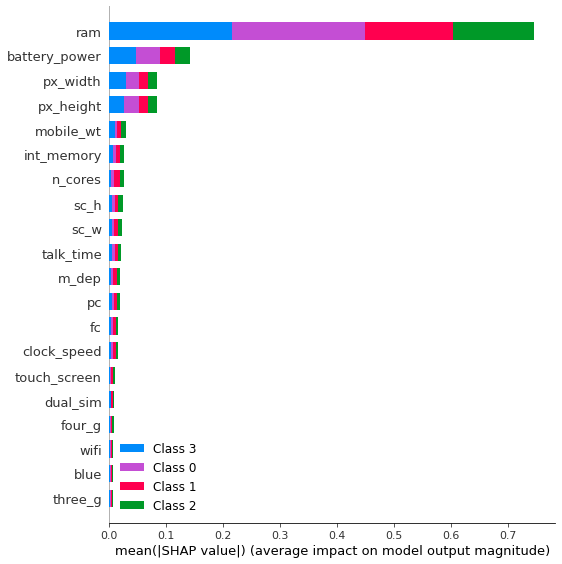

In [22]:
# explain all the predictions in the test set
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)



*  We can again see that RAM, Battery Power, Height and pixel affect the model
*  We can see that there are more no. of expensive class 3 phone present in the dataset



## Summary plot for a single class


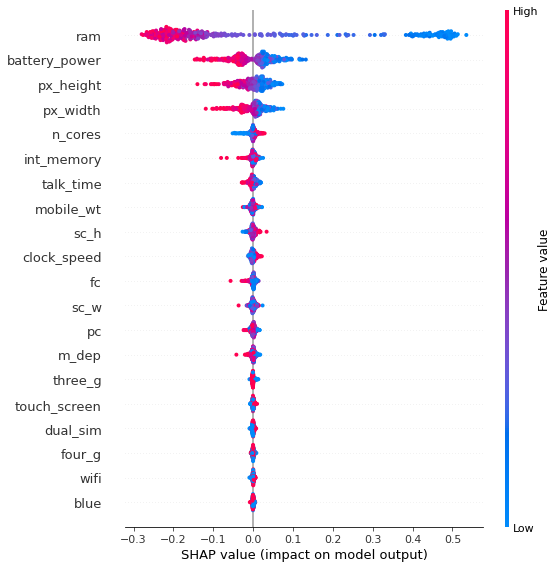

In [23]:
shap.initjs()
shap.summary_plot(shap_values[0], X_test)

Red denotes a low feature value, whereas blue denotes a high feature value. As we can see, low ram values increase the likelihood of belonging to class 0. Similarly, low battery power, px width, and px height values increase the likelihood of belonging to class 0. If you look at the class 3 summary density map, you will notice the exact reverse of class 0, i.e. low ram values push down the probability of belonging to class 3 the higher the price range, which is a reasonable conclusion.

### Decision Plot


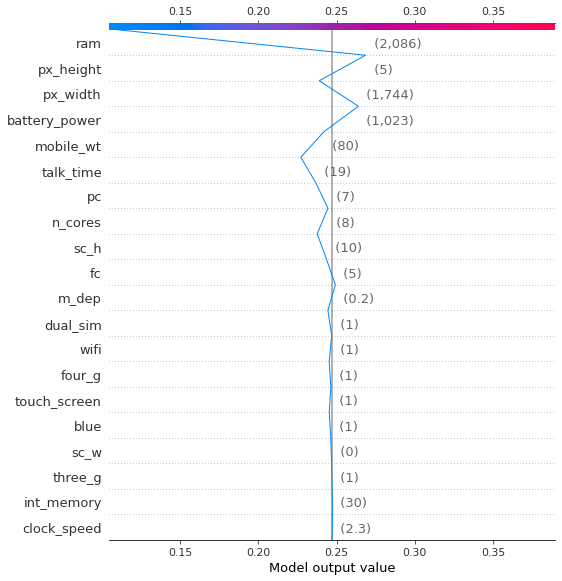

In [24]:
shap.initjs()
shap.decision_plot(explainer.expected_value[0], 
                shap_values[0][3,:], X_test.iloc[3,:])

### This decision plot can show how predictions vary when a collection of feature values changes. 

## 3. Running AutoML to find out the best model

In [25]:

# Prepare the data for AutoML
# Download the train data csv file and load in the training dataset 
url = "https://raw.githubusercontent.com/pratikg17neu/DS_6105__Assignment1/proper-dataset/dataset/train.csv"
df_aml = h2o.import_file(path = url)
pct_rows=0.80
df_aml_train, df_aml_test = df_aml.split_frame([pct_rows])
X_aml = df_aml_train.columns

y_aml = 'price_range'
X_aml.remove(y_aml)

# Set up AutoML
aml = H2OAutoML(max_runtime_secs=run_time, seed=1)

aml.train(x=X_aml,y=y_aml,training_frame=df_aml_train)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_4_AutoML_1_20220424_234747

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.01250078967416956
RMSE: 0.11180693034946251
MAE: 0.08878397049781425
RMSLE: 0.05582274800385669
R^2: 0.9899173822260711
Mean Residual Deviance: 0.01250078967416956
Null degrees of freedom: 1591
Residual degrees of freedom: 1586
Null deviance: 1973.8184673366775
Residual deviance: 19.90125716127794
AIC: -2444.1855429515654

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.06802136159326683
RMSE: 0.2608090519772403
MAE: 0.1896961451410345
RMSLE: 0.12871233899547388
R^2: 0.9451367947719129
Mean Residual Deviance: 0.0680

,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,mae,0.189521,0.011966,0.169657,0.192720,0.198897,0.198334,0.187996
1,mean_residual_deviance,0.067990,0.006816,0.058116,0.071023,0.074783,0.072076,0.063954
2,mse,0.067990,0.006816,0.058116,0.071023,0.074783,0.072076,0.063954
3,null_deviance,395.283720,16.918703,402.943540,385.617370,401.865940,371.327180,414.664550
4,r2,0.944849,0.007058,0.954541,0.940779,0.938936,0.939810,0.950178
5,residual_deviance,21.654890,2.306915,18.306670,22.585320,24.454065,22.271366,20.657034
6,rmse,0.260480,0.013256,0.241073,0.266501,0.273465,0.268469,0.252891
7,rmsle,0.128395,0.010000,0.115249,0.128697,0.139658,0.136220,0.122153


In [26]:
print(aml.leaderboard)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_BestOfFamily_4_AutoML_1_20220424_234747,0.260809,0.0680214,0.189696,0.128712,0.0680214
StackedEnsemble_AllModels_3_AutoML_1_20220424_234747,0.262502,0.0689072,0.190041,0.128921,0.0689072
StackedEnsemble_AllModels_2_AutoML_1_20220424_234747,0.266618,0.071085,0.200824,0.131542,0.071085
StackedEnsemble_BestOfFamily_3_AutoML_1_20220424_234747,0.266883,0.0712268,0.203516,0.132064,0.0712268
StackedEnsemble_AllModels_1_AutoML_1_20220424_234747,0.271316,0.0736121,0.202959,0.13483,0.0736121
StackedEnsemble_BestOfFamily_2_AutoML_1_20220424_234747,0.273217,0.0746475,0.205452,0.136612,0.0746475
GBM_grid_1_AutoML_1_20220424_234747_model_12,0.275843,0.0760893,0.184226,0.138956,0.0760893
GBM_grid_1_AutoML_1_20220424_234747_model_2,0.275857,0.0760972,0.208122,0.137104,0.0760972
GBM_grid_1_AutoML_1_20220424_234747_model_5,0.276066,0.0762122,0.190401,0.13694,0.0762122
GBM_4_AutoML_1_20220424_234747,0.279786,0.0782803,0.205228,0.139759,0.0782803


In [27]:
model_index=0
glm_index=0
glm_model=''
aml_leaderboard_df=aml.leaderboard.as_data_frame()
models_dict={}
for m in aml_leaderboard_df['model_id']:
  models_dict[m]=model_index
  if 'StackedEnsemble' not in m:
    break 
  model_index=model_index+1  

for m in aml_leaderboard_df['model_id']:
  if 'GLM' in m:
    models_dict[m]=glm_index
    break  
  glm_index=glm_index+1     
models_dict


{'GBM_grid_1_AutoML_1_20220424_234747_model_12': 6,
 'GLM_1_AutoML_1_20220424_234747': 52,
 'StackedEnsemble_AllModels_1_AutoML_1_20220424_234747': 4,
 'StackedEnsemble_AllModels_2_AutoML_1_20220424_234747': 2,
 'StackedEnsemble_AllModels_3_AutoML_1_20220424_234747': 1,
 'StackedEnsemble_BestOfFamily_2_AutoML_1_20220424_234747': 5,
 'StackedEnsemble_BestOfFamily_3_AutoML_1_20220424_234747': 3,
 'StackedEnsemble_BestOfFamily_4_AutoML_1_20220424_234747': 0}

In [28]:
print(model_index)
best_model = h2o.get_model(aml.leaderboard[model_index,'model_id'])

6


In [29]:
best_model.algo

'gbm'

## AutoML suggested **GBM Gradient Boosting Machine** model works best

In [30]:
gbm_model = GradientBoostingClassifier()
gbm_model.fit(X_train, y_train)
gbm_model.score(X_test, y_test)

0.915

#### Gradient Boosting Machine has accuracy of `92.275%`

In [31]:
lb = aml.leaderboard
lb
bst_model = aml.leader

feature_names = list(X_train.columns)

In [32]:
class H2OProbWrapper:
    def __init__(self, h2o_model, feature_names):
        self.h2o_model = h2o_model
        self.feature_names = feature_names

    def predict_binary_prob(self, X):
        if isinstance(X, pd.Series):
            X = X.values.reshape(1,-1)
        self.dataframe= pd.DataFrame(X, columns=self.feature_names)
        self.predictions = self.h2o_model.predict(h2o.H2OFrame(self.dataframe)).as_data_frame().values
        return self.predictions.astype('float64')[:,-1] #probability of True class

In [33]:
h2o_wrapper = H2OProbWrapper(bst_model,feature_names) 


In [34]:
X_train.shape[0]


1600

In [35]:
explainer = shap.KernelExplainer(h2o_wrapper.predict_binary_prob, X_train.iloc[:100,:])


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [36]:
shap.initjs()
shap_values = explainer.shap_values(X_test.iloc[:50], nsamples=500)
shap.force_plot(explainer.expected_value, shap_values, X_test.iloc[:50])

  0%|          | 0/50 [00:00<?, ?it/s]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Parse progress: |█████████████████████████████████

We are having similar result as the eairler model.

## Waterfall Plot

In [39]:
explainer = shap.Explainer(gbm_model.predict, X_train)
shap_values = explainer(X_test)

Permutation explainer: 401it [02:01,  3.14it/s]


In [40]:
def sample_feature_importance(idx, type='condensed'):
    if type == 'condensed':
        return shap.plots.force(shap_values[idx])
    elif type == 'waterfall':
        return shap.plots.waterfall(shap_values[idx])
    else:
        return "Return valid visual ('condensed', 'waterfall')"

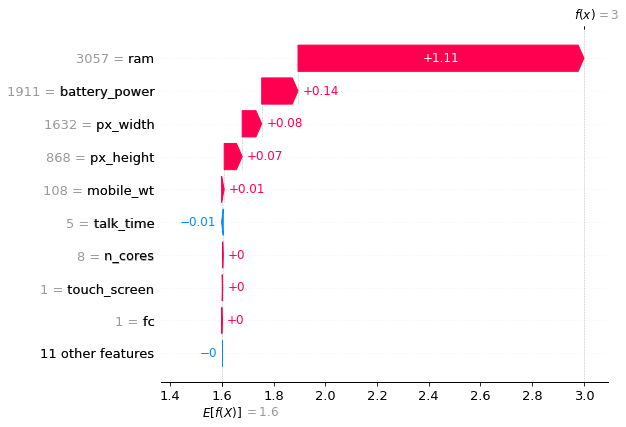

In [41]:
sample_feature_importance(0, 'waterfall')


The value in the red push the value upside and the value in blue bring the value down. We can see that ram is pushing the value up

In [42]:
shap.initjs()
sample_feature_importance(0, 'condensed')

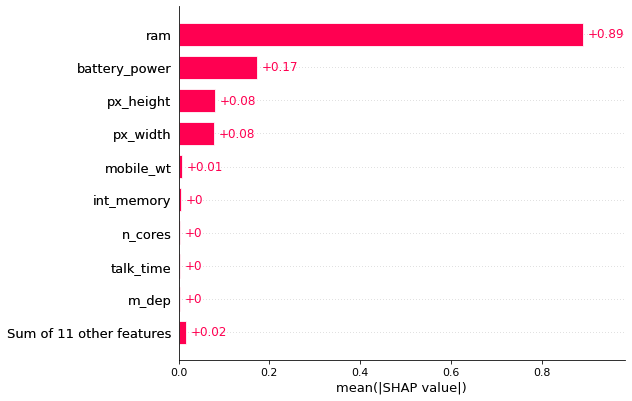

In [43]:
shap.plots.bar(shap_values)

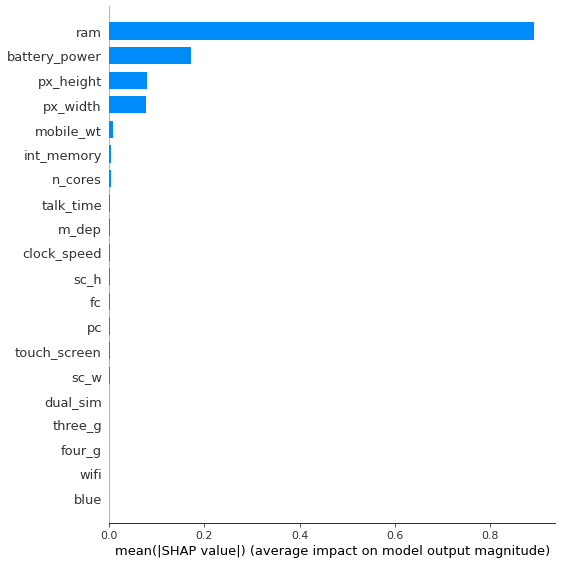

In [44]:
shap.summary_plot(shap_values.values, X_train, plot_type='bar')

We can deduce that all four feature have a significant effect on the output.

# Partial Dependence Plot on ram and battery_power

In [45]:
def partial_dependence_plot(feature, idx=None):
    if idx is None: # visualize all samples
        shap.plots.partial_dependence(
            feature,
            gbm_model.predict,
            X_train, 
            ice=False,
            model_expected_value=True, 
            feature_expected_value=True)
    else: # visualize sample idx
        shap.partial_dependence_plot(
            feature, 
            gbm_model.predict,
            X_train, 
            ice=False,
            model_expected_value=True, 
            feature_expected_value=True,
            shap_values=shap_values[idx:idx+1,:])

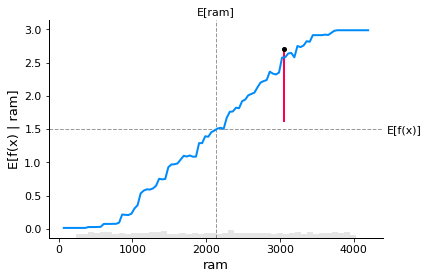

In [46]:
partial_dependence_plot('ram', 0)


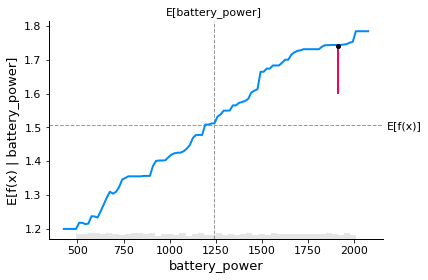

In [47]:
partial_dependence_plot('battery_power', 0)


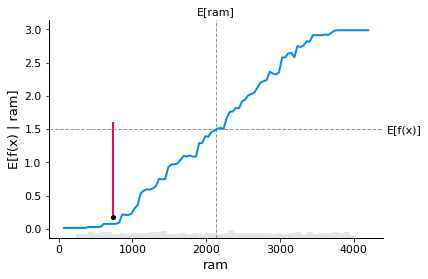

In [48]:
partial_dependence_plot('ram', 1)


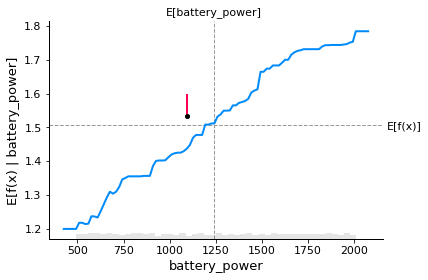

In [49]:
partial_dependence_plot('battery_power', 1)


From both the plot we can decude that battery_power and ram have the most impact on the output.

In [50]:
h2o.cluster().shutdown()

H2O session _sid_be19 closed.


# Conclusion

In this notebook we have trained our dataset on three model, and then performed the SHAP analysis on each model, for every model and shap analysis we find that the there are 4 important feature which are significant for that output. 

MIT License

 

Copyright (c) 2022 Pratik Gawand

 

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

 

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

 

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

## Reference

- https://shap.readthedocs.io/en/latest/tabular_examples.html
- https://github.com/aiprobably/SHAP
- https://www.youtube.com/watch?v=m60swo-th4E
- https://medium.com/dataman-in-ai/the-shap-values-with-h2o-models-773a203b75e3